In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train_32000.csv', )
train = train.drop(['Unnamed: 0'], axis=1)
train.head(5)

,image,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.3225,88.245,184.4820,88.5780,183.6495,115.551,184.4820,138.8610,183.4830,...,177.489,39.96,179.4870,37.9620,175.1580,38.1285,183.3165,40.959,171.4950,41.2920
1,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,176.8230,87.912,184.3155,87.9120,183.6495,115.551,184.1490,140.6925,183.4830,...,177.489,39.96,179.8200,37.9620,175.1580,38.2950,183.3165,40.959,171.9945,41.2920
2,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,183.9825,88.4115,183.6495,115.551,184.1490,141.1920,183.3165,...,177.489,39.96,179.6535,38.1285,174.9915,38.1285,183.3165,40.959,171.9945,41.4585
3,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,184.6485,88.5780,183.6495,115.551,184.1490,140.1930,183.3165,...,177.489,39.96,179.4870,38.1285,174.9915,38.2950,183.3165,40.959,171.8280,41.2920
4,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,183.9825,88.5780,183.6495,115.551,183.6495,139.6935,183.6495,...,177.489,39.96,179.8200,38.1285,174.9915,38.4615,183.3165,40.959,172.1610,41.2920


In [4]:
train_paths = list(train['image'])

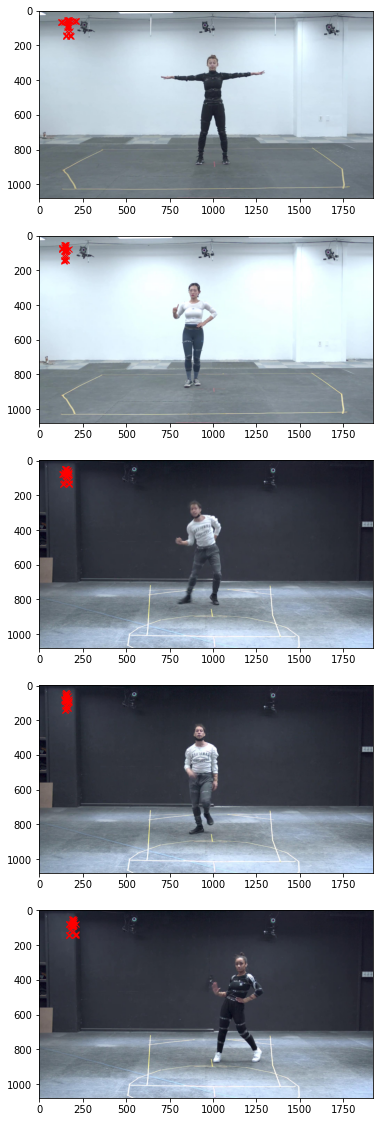

In [5]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:59] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

In [6]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['image'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        img = img/255                         # 이미지 rescaling
        target = train.iloc[:,1:59].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)


#generator를 활용해 데이터셋 만들기        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([58])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [7]:
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Activation, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [8]:
#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(58))

In [9]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [10]:
model.fit(train_dataset,epochs = 20, verbose=1)

Epoch 1/20
1000/1000 [==============================] - 6883s 7s/step - loss: 438.8297 - mae: 15.2409
Epoch 2/20
1000/1000 [==============================] - 7196s 7s/step - loss: 357.0475 - mae: 13.9196
Epoch 3/20
1000/1000 [==============================] - 6903s 7s/step - loss: 296.7091 - mae: 12.0671
Epoch 4/20
1000/1000 [==============================] - 6912s 7s/step - loss: 211.2759 - mae: 10.7617
Epoch 5/20
1000/1000 [==============================] - 6983s 7s/step - loss: 198.9794 - mae: 10.4640
Epoch 6/20
1000/1000 [==============================] - 6897s 7s/step - loss: 178.9635 - mae: 9.8810
Epoch 7/20
1000/1000 [==============================] - 6948s 7s/step - loss: 173.7269 - mae: 9.7774
Epoch 8/20
1000/1000 [==============================] - 6960s 7s/step - loss: 159.3180 - mae: 9.4188
Epoch 9/20
1000/1000 [==============================] - 6960s 7s/step - loss: 146.3474 - mae: 9.0050
Epoch 10/20
1000/1000 [==============================] - 6652s 7s/step - loss: 145.820

In [11]:
from keras.models import load_model

model.save('data_32000_epoch_20')  # creates a HDF5 file 'my_model.h5'

INFO:tensorflow:Assets written to: data_32000_epoch_20\assets


In [12]:
test = pd.read_csv('original_test.csv', )
test = test.drop(['Unnamed: 0'], axis=1)
test = test[:200]
test

,image,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,558,940,771,930,926,918,...,923,241,939,222,904,223,966,237,877,234
1,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,771,930,926,918,...,923,241,939,222,904,223,966,237,882,240
2,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,777,930,921,918,...,923,241,939,222,904,223,966,237,882,240
3,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,777,930,921,918,...,923,241,939,222,904,223,966,237,882,240
4,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,777,930,921,918,...,923,241,939,222,904,223,966,237,882,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,920,560,970,559,938,770,929,933,912,...,934,257,953,236,920,234,974,239,887,236
196,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,920,561,965,559,938,773,928,936,914,...,934,254,952,236,920,235,975,242,886,235
197,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,914,565,968,558,938,770,930,934,913,...,936,258,952,240,919,235,974,242,888,236
198,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,920,561,971,559,938,770,929,941,913,...,931,255,952,236,919,235,973,240,886,235


In [13]:
test_paths = test['image']

In [14]:
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    X_test.append(img)

100%|██████████| 200/200 [00:05<00:00, 34.27it/s]


In [15]:
X_test=tf.stack(X_test, axis=0)
X_test.shape

TensorShape([200, 180, 320, 3])

In [26]:
pred=model.predict(X_test)

In [33]:
predict = pd.DataFrame(pred, columns = ["center_hip_x", "center_hip_y", "left_hip_x", "left_hip_y", "left_knee_x", "left_knee_y", "left_ankle_x", "left_ankle_y", "left_bigtoe_X", "left_bigtoe_y",
                "left_littletoe_x", "left_littletoe_y", "right_hip_x", "right_hip_y", "right_knee_x", "right_knee_y", "right_ankle_x", "right_ankle_y", "right_bigtoe_x", "right_bigtoe_y",
                "right_littletoe_x", "right_littletoe_y", "navel_x", "navel_y", "chest_x", "chest_y", "neck_x", "neck_y", "left_shoulder_x", "left_shoulder_y", "left_elbow_x", "left_elbow_y",
                "left_wrist_x", "left_wrist_y", "left_palm_thumb_x", "left_palm_thumb_y", "left_palm_pinky_x", "left_palm_pinky_y", "right_shoulder_x", "right_shoulder_y", "right_elbow_x", "right_elbow_y",
                "right_wrist_x", "right_wrist_y", "right_palm_thumb_x", "right_palm_thumb_y", "right_palm_pinky_x", "right_palm_pinky_y", "nose_x", "nose_y", "left_eye_x", "left_eye_y",
                "right_eye_x", "right_eye_y", "left_ear_x", "left_ear_y", "right_ear_x", "right_ear_y"])

predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,8796.674805,4238.183105,9257.132812,4522.733887,9477.300781,6039.990723,9757.832031,7962.929199,10073.736328,8966.987305,...,8667.361328,1914.377686,9039.829102,1948.533569,8281.671875,1818.288818,8985.834961,1669.761597,8344.831055,2469.076172
1,8772.854492,4214.690918,9223.231445,4520.242188,9441.376953,6033.582520,9741.783203,7962.162598,10084.043945,8980.157227,...,8633.093750,1871.015503,9033.534180,1918.511597,8242.490234,1769.377197,8960.752930,1616.755981,8322.440430,2479.624023
2,8750.668945,4211.185059,9203.052734,4510.439453,9419.425781,6025.384277,9709.740234,7943.229980,10049.330078,8955.002930,...,8611.068359,1879.630127,9006.952148,1920.070190,8224.138672,1775.875854,8936.661133,1628.235474,8299.557617,2471.606934
3,8746.845703,4213.000488,9197.032227,4516.154297,9413.974609,6031.269043,9710.387695,7950.079590,10053.154297,8962.652344,...,8604.722656,1878.444580,9005.529297,1921.320435,8216.962891,1773.717773,8932.516602,1623.585571,8294.803711,2481.224854
4,8750.671875,4296.996094,9188.142578,4612.606445,9404.700195,6099.574707,9681.056641,7983.950195,10011.955078,8994.935547,...,8610.928711,1982.906250,8985.200195,2034.096558,8227.990234,1883.599976,8926.070312,1723.734985,8290.024414,2574.546387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,8435.017578,4481.642090,8862.114258,4777.684570,9182.849609,6151.891113,9341.439453,7810.199707,9588.885742,8700.438477,...,8416.328125,2251.111084,8696.218750,2294.083008,8045.700684,2198.361328,8632.967773,2044.668213,8026.200195,2734.650146
196,8462.360352,4494.003418,8892.266602,4784.917969,9213.701172,6167.261230,9362.315430,7836.763184,9591.111328,8718.732422,...,8442.025391,2256.101074,8715.314453,2293.586426,8077.424316,2211.605469,8664.587891,2064.046143,8049.023438,2715.991943
197,8405.022461,4475.114746,8829.928711,4775.474609,9141.443359,6153.239746,9303.542969,7806.451660,9560.353516,8706.714844,...,8384.921875,2243.259521,8670.590820,2288.529297,8012.190918,2181.837402,8600.515625,2028.699463,7997.457031,2741.360352
198,8430.170898,4479.516602,8855.403320,4780.030273,9170.443359,6159.575195,9332.296875,7819.096191,9583.970703,8719.146484,...,8412.234375,2240.888916,8696.534180,2287.357910,8038.891602,2184.540039,8627.680664,2029.666382,8021.043945,2738.837646


In [34]:
# 좌표값에 8곱하기
predict = predict * 8
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,924.117493,529.614685,965.921753,533.742188,943.507507,694.783997,983.854614,799.907654,972.774475,857.249329,...,924.075439,264.837372,928.944824,253.696487,916.793457,254.973221,952.636963,270.912354,899.125244,266.967804
1,926.250000,530.595764,968.221741,534.732422,945.725342,696.205566,986.154175,801.564209,975.025146,859.042297,...,926.195923,265.200409,931.080444,254.046066,918.918335,255.333862,954.859009,271.309021,901.199524,267.360260
2,922.528748,528.768188,964.330261,532.888794,941.945984,693.764099,982.162048,798.798218,971.103821,856.065735,...,922.466675,264.340363,927.343201,253.221649,915.184631,254.498901,951.013489,270.419617,897.501221,266.498413
3,924.004028,529.535217,965.915588,533.660278,943.485901,694.722717,983.800171,799.878662,972.737122,857.241211,...,923.933044,264.701752,928.821716,253.573288,916.675659,254.874908,952.568604,270.800354,898.953003,266.907318
4,924.551392,528.287231,965.739624,532.396729,943.275940,692.528992,984.156067,796.796631,972.931213,853.902771,...,924.561829,264.463226,929.351685,253.346985,917.518372,254.627869,952.978882,270.459930,900.298035,266.416565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,889.360352,539.152588,925.615295,542.836670,922.498840,687.111633,961.138000,788.128662,956.633118,841.183228,...,890.087585,289.730927,896.137085,278.481934,881.615479,279.373108,918.434814,293.644470,866.203369,290.577362
196,890.255127,539.442993,926.518555,543.127808,923.178955,687.575623,961.887451,788.662476,957.307190,841.785828,...,890.979919,289.759583,897.014526,278.498718,882.511658,279.389618,919.326904,293.682434,867.087769,290.596985
197,889.300659,539.325867,925.553162,543.003662,922.189270,687.277405,960.844543,788.324036,956.308777,841.431885,...,890.054321,289.777405,896.085327,278.512085,881.575012,279.405060,918.381348,293.685059,866.111938,290.619812
198,887.395813,538.508484,923.610168,542.177429,920.239563,686.036560,958.818909,786.835266,954.314819,839.846741,...,888.156250,289.466187,894.182373,278.218567,879.684814,279.112915,916.457397,293.364502,864.229370,290.314545


In [18]:
# 좌표값에 6곱하기
predict = predict * 6
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,52780.046875,25429.097656,55542.796875,27136.402344,56863.804688,36239.945312,58546.992188,47777.574219,60442.417969,53801.921875,...,52004.167969,11486.265625,54238.976562,11691.201172,49690.031250,10909.732422,53915.007812,10018.569336,50068.984375,14814.457031
1,52637.125000,25288.144531,55339.390625,27121.453125,56648.261719,36201.496094,58450.699219,47772.976562,60504.265625,53880.945312,...,51798.562500,11226.092773,54201.203125,11511.069336,49454.941406,10616.263672,53764.515625,9700.536133,49934.640625,14877.744141
2,52504.015625,25267.109375,55218.316406,27062.636719,56516.554688,36152.304688,58258.441406,47659.378906,60295.980469,53730.015625,...,51666.410156,11277.781250,54041.710938,11520.420898,49344.832031,10655.254883,53619.968750,9769.413086,49797.343750,14829.641602
3,52481.074219,25278.003906,55182.195312,27096.925781,56483.847656,36187.613281,58262.328125,47700.476562,60318.925781,53775.914062,...,51628.335938,11270.667969,54033.175781,11527.922852,49301.777344,10642.306641,53595.101562,9741.513672,49768.820312,14887.349609
4,52504.031250,25781.976562,55128.855469,27675.638672,56428.203125,36597.449219,58086.339844,47903.703125,60071.730469,53969.613281,...,51665.570312,11897.437500,53911.203125,12204.579102,49367.941406,11301.599609,53556.421875,10342.410156,49740.148438,15447.278320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50610.105469,26889.851562,53172.687500,28666.107422,55097.097656,36911.347656,56048.636719,46861.199219,57533.312500,52202.632812,...,50497.968750,13506.666016,52177.312500,13764.498047,48274.203125,13190.167969,51797.804688,12268.009766,48157.203125,16407.900391
196,50774.164062,26964.019531,53353.601562,28709.507812,55282.207031,37003.566406,56173.890625,47020.578125,57546.667969,52312.394531,...,50652.152344,13536.606445,52291.886719,13761.518555,48464.546875,13269.632812,51987.527344,12384.277344,48294.140625,16295.951172
197,50430.132812,26850.687500,52979.570312,28652.847656,54848.660156,36919.437500,55821.257812,46838.710938,57362.121094,52240.289062,...,50309.531250,13459.556641,52023.546875,13731.175781,48073.144531,13091.024414,51603.093750,12172.197266,47984.742188,16448.162109
198,50581.023438,26877.099609,53132.421875,28680.181641,55022.660156,36957.453125,55993.781250,46914.578125,57503.824219,52314.878906,...,50473.406250,13445.333984,52179.203125,13724.147461,48233.351562,13107.240234,51766.085938,12177.998047,48126.265625,16433.025391


In [30]:
predict = predict * 0.2
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,1759.334961,847.636658,1851.426636,904.546814,1895.460205,1207.998169,1951.566406,1592.585815,2014.747314,1793.397461,...,1733.472290,382.875549,1807.965820,389.706726,1656.334351,363.657776,1797.166992,333.952332,1668.966187,493.815247
1,1754.570923,842.938171,1844.646362,904.048462,1888.275391,1206.716553,1948.356689,1592.432495,2016.808838,1796.031494,...,1726.618774,374.203094,1806.706909,383.702332,1648.498047,353.875458,1792.150635,323.351196,1664.488159,495.924805
2,1750.133789,842.237000,1840.610596,902.087891,1883.885132,1205.076904,1941.948120,1588.645996,2009.866089,1791.000610,...,1722.213745,375.926025,1801.390503,384.014038,1644.827759,355.175171,1787.332275,325.647095,1659.911499,494.321381
3,1749.369141,842.600098,1839.406494,903.230896,1882.794922,1206.253784,1942.077515,1590.015991,2010.630859,1792.530518,...,1720.944580,375.688934,1801.105835,384.264099,1643.392578,354.743561,1786.503296,324.717133,1658.960815,496.244965
4,1750.134399,859.399231,1837.628540,922.521301,1880.940063,1219.914917,1936.211304,1596.790039,2002.390991,1798.987183,...,1722.185791,396.581268,1797.040039,406.819305,1645.598022,376.720001,1785.214111,344.747009,1658.004883,514.909302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1687.003540,896.328430,1772.422852,955.536926,1836.569946,1230.378296,1868.287964,1562.039917,1917.777222,1740.087769,...,1683.265625,450.222229,1739.243774,458.816620,1609.140137,439.672272,1726.593628,408.933655,1605.240112,546.930054
196,1692.472046,898.800720,1778.453369,956.983582,1842.740234,1233.452271,1872.463135,1567.352661,1918.222290,1743.746460,...,1688.405151,451.220215,1743.062866,458.717285,1615.484863,442.321106,1732.917603,412.809235,1609.804688,543.198425
197,1681.004517,895.022949,1765.985718,955.094910,1828.288696,1230.647949,1860.708618,1561.290405,1912.070679,1741.343018,...,1676.984375,448.651917,1734.118164,457.705872,1602.438232,436.367493,1720.103149,405.739899,1599.491455,548.272095
198,1686.034180,895.903320,1771.080688,956.006042,1834.088745,1231.915039,1866.459351,1563.819214,1916.794189,1743.829346,...,1682.446899,448.177795,1739.306885,457.471588,1607.778320,436.908020,1725.536133,405.933289,1604.208862,547.767517


In [34]:
predict = predict // 255
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,34.0,16.0,36.0,17.0,37.0,23.0,38.0,31.0,39.0,35.0,...,33.0,7.0,35.0,7.0,32.0,7.0,35.0,6.0,32.0,9.0
1,34.0,16.0,36.0,17.0,37.0,23.0,38.0,31.0,39.0,35.0,...,33.0,7.0,35.0,7.0,32.0,6.0,35.0,6.0,32.0,9.0
2,34.0,16.0,36.0,17.0,36.0,23.0,38.0,31.0,39.0,35.0,...,33.0,7.0,35.0,7.0,32.0,6.0,35.0,6.0,32.0,9.0
3,34.0,16.0,36.0,17.0,36.0,23.0,38.0,31.0,39.0,35.0,...,33.0,7.0,35.0,7.0,32.0,6.0,35.0,6.0,32.0,9.0
4,34.0,16.0,36.0,18.0,36.0,23.0,37.0,31.0,39.0,35.0,...,33.0,7.0,35.0,7.0,32.0,7.0,35.0,6.0,32.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,33.0,17.0,34.0,18.0,36.0,24.0,36.0,30.0,37.0,34.0,...,33.0,8.0,34.0,8.0,31.0,8.0,33.0,8.0,31.0,10.0
196,33.0,17.0,34.0,18.0,36.0,24.0,36.0,30.0,37.0,34.0,...,33.0,8.0,34.0,8.0,31.0,8.0,33.0,8.0,31.0,10.0
197,32.0,17.0,34.0,18.0,35.0,24.0,36.0,30.0,37.0,34.0,...,32.0,8.0,34.0,8.0,31.0,8.0,33.0,7.0,31.0,10.0
198,33.0,17.0,34.0,18.0,35.0,24.0,36.0,30.0,37.0,34.0,...,32.0,8.0,34.0,8.0,31.0,8.0,33.0,7.0,31.0,10.0


In [35]:
my_test = pd.concat([test['image'], predict], axis=1)

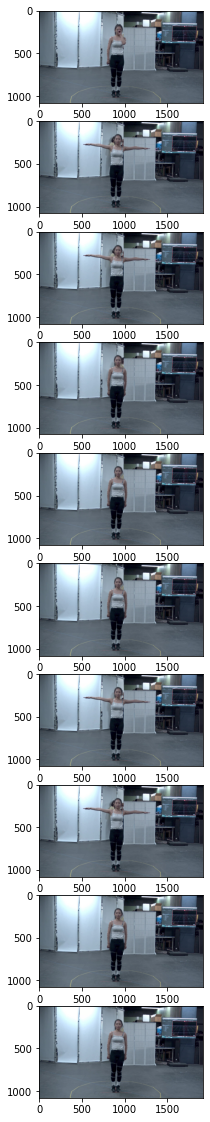

In [24]:
# 학습시킬 때 좌표값에 1/6했으니 테스할때 다시 6곱해준 것
# 테스트

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:59] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count+=1
    

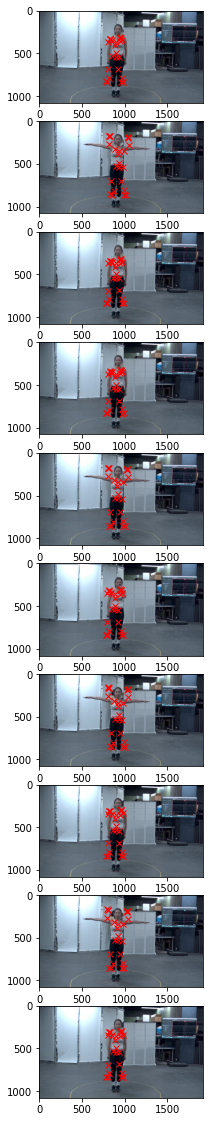

In [36]:
# 좌표갑에 8곱한것(그냥 추측성)
# 테스트

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:59] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

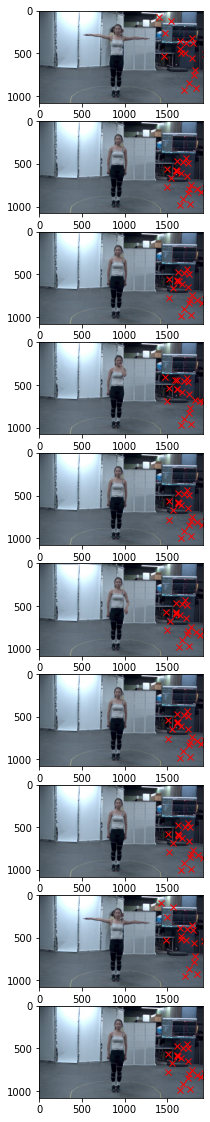

In [32]:
# 좌표갑에 8곱한것(그냥 추측성)
# 테스트

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:59] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1